# Task 1: One-to-one Training

In [ ]:
import torch
import torch.nn as nn
import os
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import matplotlib.pyplot as plt


## Fourier Neural Operator Definition

In [ ]:
from FNO import FNO1d

## Training

### Import Data 

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [ ]:
n_train = 1024 # number of training samples
n_val = 32
n_test = 256

# train dataset shape: (1024, 5, 128)
# 1024: number of trajectories
# 5: time snapthots of the solution: t= 0, 0.25, 0.5, 0.75, 1.0
# 128: spatial resolution of the data
train_dataset = torch.from_numpy(np.load("data/data_train_128.npy")).type(torch.float32)
test_dataset = torch.from_numpy(np.load("data/data_test_128.npy")).type(torch.float32)
# extract initial condition
u0_train = train_dataset[:, 0, :] 
u0_test = test_dataset[:, 0, :]
# extract solution at t=1.0
u1_train = train_dataset[:, -1, :]
u1_test = test_dataset[:, -1, :]

# Create grid coordinates
grid_size = u0_train.shape[1]  # 128
grid = torch.linspace(0, 1, grid_size).reshape(1, grid_size, 1)

# Add grid coordinates to input: shape (batch, spatial_points, 2)
u0_train_with_grid = torch.cat([u0_train.unsqueeze(-1), grid.repeat(u0_train.shape[0], 1, 1)], dim=-1)
u0_test_with_grid = torch.cat([u0_test.unsqueeze(-1), grid.repeat(u0_test.shape[0], 1, 1)], dim=-1)

batch_size = 20

training_set = DataLoader(TensorDataset(u0_train_with_grid, u1_train), batch_size=batch_size, shuffle=True)
test_set = DataLoader(TensorDataset(u0_test_with_grid, u1_test), batch_size=batch_size, shuffle=False)

### Training Parameters

In [10]:
learning_rate = 0.001
epochs  = 250
step_size = 50
gamma = 0.5

In [11]:
modes = 16
width = 64
fno = FNO1d(modes, width) # model

optimizer = torch.optim.Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

### Training

In [12]:
l = torch.nn.MSELoss()
freq_print = 1

for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set):
        optimizer.zero_grad()
        output_pred_batch = fno(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set)

    scheduler.step()
    with torch.no_grad():
        fno.eval()
        test_relative_l2 = 0.0
        for step, (input_batch, output_batch) in enumerate(test_set):
            output_pred_batch = fno(input_batch).squeeze(2)
            loss_f = (torch.mean((output_pred_batch - output_batch) ** 2) / torch.mean(output_batch ** 2)) ** 0.5 * 100
            test_relative_l2 += loss_f.item()
        test_relative_l2 /= len(test_set)

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:", test_relative_l2)


######### Epoch: 0  ######### Train Loss: 0.421103835105896  ######### Relative L2 Test Norm: 93.9660873413086
######### Epoch: 1  ######### Train Loss: 0.35520628094673157  ######### Relative L2 Test Norm: 86.06642150878906
######### Epoch: 2  ######### Train Loss: 0.2990089952945709  ######### Relative L2 Test Norm: 77.18170928955078
######### Epoch: 3  ######### Train Loss: 0.2403079718351364  ######### Relative L2 Test Norm: 66.35126495361328
######### Epoch: 4  ######### Train Loss: 0.17666813731193542  ######### Relative L2 Test Norm: 53.51607894897461
######### Epoch: 5  ######### Train Loss: 0.11365269869565964  ######### Relative L2 Test Norm: 40.30670928955078
######### Epoch: 6  ######### Train Loss: 0.06325917690992355  ######### Relative L2 Test Norm: 32.50878143310547
######### Epoch: 7  ######### Train Loss: 0.04067695140838623  ######### Relative L2 Test Norm: 36.642940521240234
######### Epoch: 8  ######### Train Loss: 0.05314984172582626  ######### Relative L2 Test No

### Plot Results

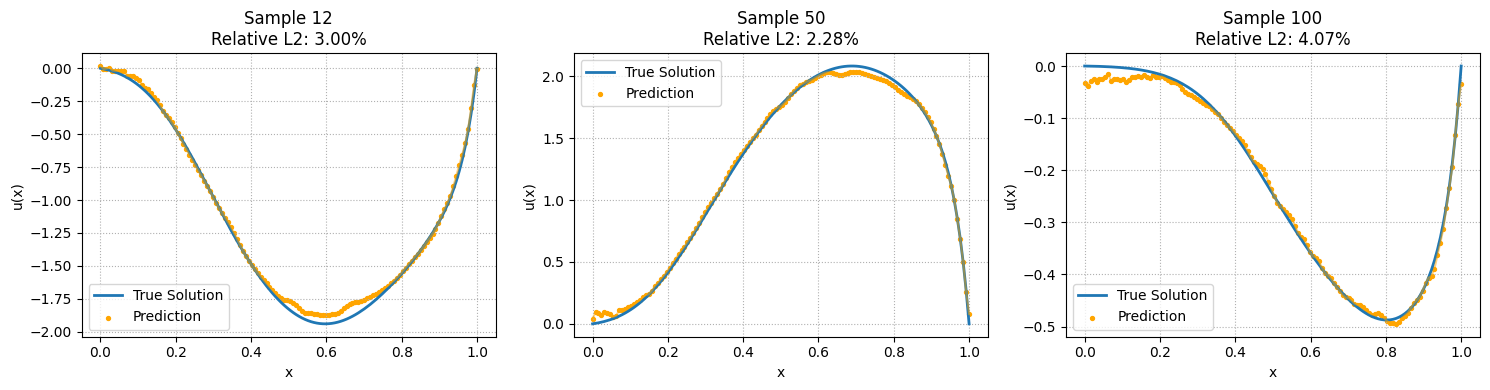

In [13]:
# Select test samples to visualize
fno.eval()
with torch.no_grad():
    # Get a few test samples
    num_samples = 3
    idx_samples = [12, 50, 100]  # Select different test samples
    
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 4))
    
    for i, idx_data in enumerate(idx_samples):
        # Get input and output for this sample
        input_sample = u0_test_with_grid[idx_data:idx_data+1]  # Shape: (1, 128, 2)
        output_true = u1_test[idx_data:idx_data+1]  # Shape: (1, 128)
        
        # Make prediction
        output_pred = fno(input_sample).squeeze(-1)  # Shape: (1, 128)
        
        # Extract grid coordinates for plotting
        grid_coords = input_sample[0, :, 1].detach()  # x coordinates
        
        # Calculate error
        p = 2
        err = (torch.mean(abs(output_true - output_pred) ** p) / torch.mean(abs(output_true) ** p)) ** (1 / p) * 100
        
        # Plot
        ax = axes[i] if num_samples > 1 else axes
        ax.grid(True, which="both", ls=":")
        ax.plot(grid_coords, output_true[0].detach(), label="True Solution", c="C0", lw=2)
        ax.scatter(grid_coords, output_pred[0].detach(), label="Prediction", s=8, c="orange")
        ax.plot(grid_coords, output_pred[0].detach(), color="orange", alpha=0.5)
        ax.set_title(f"Sample {idx_data}\nRelative L2: {err.item():.2f}%")
        ax.set_xlabel("x")
        ax.set_ylabel("u(x)")
        ax.legend()
    
    plt.tight_layout()
    plt.show()